# Libraries

In [32]:
#These are the libraries necessary to run the code

#!pip install census
#!pip install us
#!pip install pandas
#!pip install sklearn
#!pip install numpy
#!pip install matplotlib 
#!pip install geopandas  #Important in order to run map visualizations of Orleans Parish

In [33]:
from census import Census
from us import states
import pandas as pd
import json
import sklearn
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Census Cluster Data

2010 6 variables for kcluster

In [34]:
#census code for accessing census data.
c = Census("978e5226dac64954634882c701cdba3807148028")

In [35]:
#Download necessary variables from census
acs5_2010_Cluster = json.dumps(c.acs5.state_county_tract(( 'B01003_001E', 'B25077_001E', 'B25064_001E', 'B06010_001E', 'B16010_041E', 'B02001_002E', 'B25001_001E', 'B25024_002E' ), states.LA.fips, '071', Census.ALL, year=2010))
acs5_2010_Cluster_df = pd.read_json(acs5_2010_Cluster)
acs5_2010_Cluster_df.rename(columns={'B01003_001E': 'total population'}, inplace=True, errors='raise')
acs5_2010_Cluster_df.rename(columns={'B25077_001E': 'median housing value'}, inplace=True, errors='raise')
acs5_2010_Cluster_df.rename(columns={'B25064_001E': 'median gross rent (dollars)'}, inplace=True, errors='raise')
acs5_2010_Cluster_df.rename(columns={'B06010_001E': 'estimate household income'}, inplace=True, errors='raise')
acs5_2010_Cluster_df.rename(columns={'B16010_041E': 'estimate population with bachelors degree or above'}, inplace=True, errors='raise')
acs5_2010_Cluster_df.rename(columns={'B02001_002E': 'white population'}, inplace=True, errors='raise')
acs5_2010_Cluster_df.rename(columns={'B25001_001E': 'total housing units'}, inplace=True, errors='raise')
acs5_2010_Cluster_df.rename(columns={'B25024_002E': 'single unit housing units'}, inplace=True, errors='raise')


#Use some variables to derive final variables
#for %persons with college degrees
acs5_2010_Cluster_df['percent college educated'] = (acs5_2010_Cluster_df['estimate population with bachelors degree or above']/acs5_2010_Cluster_df['total population'])*100
#for %non-white
acs5_2010_Cluster_df['percent white'] = (acs5_2010_Cluster_df['white population']/acs5_2010_Cluster_df['total population'])*100
acs5_2010_Cluster_df['percent non-white'] = 100 - (acs5_2010_Cluster_df['white population']/acs5_2010_Cluster_df['total population'])*100
#for %multihousing units
acs5_2010_Cluster_df['percent multihousing unit'] = 100 - (acs5_2010_Cluster_df['single unit housing units']/acs5_2010_Cluster_df['total housing units'])*100

#Drop variables only wanted for calculations
acs5_2010_Cluster_df.drop(['state','county',
                              #dropped bc only necessary for calculations
                              #'total population',
                              'white population','percent white',
                              'total housing units','single unit housing units',
                              'estimate population with bachelors degree or above'
                              ], axis=1, inplace=True, errors='ignore')

#Set tract as index of table
acs5_2010_Cluster_df = acs5_2010_Cluster_df.set_index("tract")
#remove tracts for which most or some attributes are NaN
#1600 and 4402 have pop =0  and are thus problematic and may be needed to be ignored
#also have various missing 901 701 1730 1734 have one missing (rent burdened)
acs5_2010_Cluster_df.drop([14500,980000,980100,990000],inplace=True)
acs5_2010_Cluster_df.drop([1600,4402,901,701,1730,1734],inplace=True)

#Check no values are null. 
print(acs5_2010_Cluster_df.isnull().sum().sum())

0


In [36]:
# Verify dimesionality of data, should be 167x7
acs5_2010_Cluster_df

,total population,median housing value,median gross rent (dollars),estimate household income,percent college educated,percent non-white,percent multihousing unit
tract,,,,,,,
100,2298,259700,1071,1976,40.861619,27.806789,58.810409
200,1447,166700,919,1244,8.500346,89.357291,55.842185
300,1012,89000,817,841,6.225296,94.169960,49.613601
400,1945,119900,1104,1474,16.349614,84.164524,24.975892
601,532,104600,229,416,4.887218,100.000000,66.473988
...,...,...,...,...,...,...,...
14000,1805,75000,283,1323,2.326870,95.290859,91.570881
14100,1446,155600,915,1098,21.023513,69.156293,92.318436
14200,1503,174100,978,1379,27.079175,59.081836,59.761388


2019 6 variables for cluster

In [37]:
#Download necessary variables from census
acs5_2019_Cluster = json.dumps(c.acs5.state_county_tract(( 'B01003_001E', 'B25077_001E', 'B25064_001E', 'B06010_001E', 'B16010_041E', 'B02001_002E', 'B25001_001E', 'B25024_002E' ), states.LA.fips, '071', Census.ALL, year=2019))
acs5_2019_Cluster_df = pd.read_json(acs5_2019_Cluster)
acs5_2019_Cluster_df.rename(columns={'B01003_001E': 'total population'}, inplace=True, errors='raise')
acs5_2019_Cluster_df.rename(columns={'B25077_001E': 'median housing value'}, inplace=True, errors='raise')
acs5_2019_Cluster_df.rename(columns={'B25064_001E': 'median gross rent (dollars)'}, inplace=True, errors='raise')
acs5_2019_Cluster_df.rename(columns={'B06010_001E': 'estimate household income'}, inplace=True, errors='raise')
acs5_2019_Cluster_df.rename(columns={'B16010_041E': 'estimate population with bachelors degree or above'}, inplace=True, errors='raise')
acs5_2019_Cluster_df.rename(columns={'B02001_002E': 'white population'}, inplace=True, errors='raise')
acs5_2019_Cluster_df.rename(columns={'B25001_001E': 'total housing units'}, inplace=True, errors='raise')
acs5_2019_Cluster_df.rename(columns={'B25024_002E': 'single unit housing units'}, inplace=True, errors='raise')

#Use some variables to derive final variables
#for %persons with college degrees
acs5_2019_Cluster_df['percent college educated'] = (acs5_2019_Cluster_df['estimate population with bachelors degree or above']/acs5_2019_Cluster_df['total population'])*100
#for %non-white
acs5_2019_Cluster_df['percent white'] = (acs5_2019_Cluster_df['white population']/acs5_2019_Cluster_df['total population'])*100
acs5_2019_Cluster_df['percent non-white'] = 100 - (acs5_2019_Cluster_df['white population']/acs5_2019_Cluster_df['total population'])*100
#for %multihousing units
acs5_2019_Cluster_df['percent multihousing unit'] = 100 - (acs5_2019_Cluster_df['single unit housing units']/acs5_2019_Cluster_df['total housing units'])*100


#Drop variables only wanted for calculations
acs5_2019_Cluster_df.drop(['state','county',
                              #dropped bc only necessary for calculations
                              'total population',
                              'white population','percent white',
                              'total housing units','single unit housing units',
                              'estimate population with bachelors degree or above'
                              ], axis=1, inplace=True, errors='ignore')

#Set tract ID as index
acs5_2019_Cluster_df = acs5_2019_Cluster_df.set_index("tract")
#remove tracts for which most or some attributes are NaN
#1600 and 4402 have pop =0  and are thus problematic and may be needed to be ignored
#also have various missing 901 701 1730 1734 have one missing (rent burdened)
acs5_2019_Cluster_df.drop([14500,980000,980100,990000],inplace=True)
acs5_2019_Cluster_df.drop([1600,4402,901,701,1730,1734],inplace=True)

#Check no values are null
print(acs5_2019_Cluster_df.isnull().sum().sum())

0


In [38]:
# Verify dimesionality of data, should be 167x7
acs5_2019_Cluster_df

,median housing value,median gross rent (dollars),estimate household income,percent college educated,percent non-white,percent multihousing unit
tract,,,,,,
1744,187500,931,3619,10.342813,99.396182,76.226226
1746,123200,1094,2949,10.314499,95.549041,19.546436
1745,161500,1013,3270,21.684054,95.901639,36.819036
1747,277700,861,3754,34.953704,100.000000,4.505716
1748,156700,1058,3563,13.761677,94.121668,5.296128
...,...,...,...,...,...,...
618,257600,1061,3773,34.797711,75.643645,25.096774
1743,254600,875,1780,16.980376,95.915098,69.359756
14300,124000,768,1474,7.739082,97.014925,85.728848


# K-Means Clustering

**K-Means Clustering**

In [39]:
#Copy original DataFrame
cluster_df = acs5_2010_Cluster_df.copy()
#Just in case drop any NaN values
cluster_df.dropna(inplace=True)

#Drop tracts for which values are erroneous, Ex negative median house value
#Tracts 1751 4800 and 6000 have median housing value equal to -666666666
#tracts 902 1701 1741 and 1747 have median gross rent (dollars) value equal to -666666666
cluster_df.drop(cluster_df.loc[cluster_df['median housing value']< 0].index, inplace=True)
cluster_df.drop(cluster_df.loc[cluster_df['median gross rent (dollars)']< 0].index, inplace=True)
#Verify dimesionality, should be 160x7
cluster_df

,total population,median housing value,median gross rent (dollars),estimate household income,percent college educated,percent non-white,percent multihousing unit
tract,,,,,,,
100,2298,259700,1071,1976,40.861619,27.806789,58.810409
200,1447,166700,919,1244,8.500346,89.357291,55.842185
300,1012,89000,817,841,6.225296,94.169960,49.613601
400,1945,119900,1104,1474,16.349614,84.164524,24.975892
601,532,104600,229,416,4.887218,100.000000,66.473988
...,...,...,...,...,...,...,...
14000,1805,75000,283,1323,2.326870,95.290859,91.570881
14100,1446,155600,915,1098,21.023513,69.156293,92.318436
14200,1503,174100,978,1379,27.079175,59.081836,59.761388


[0.6405730622708207, 0.6545081556935608, 0.6201968254808229, 0.5819607651104306, 0.56888175979856, 0.5755968713619503, 0.577387564875786, 0.5712831075550622, 0.572540670529426]


Text(0, 0.5, 'The silhouette coefficient values')

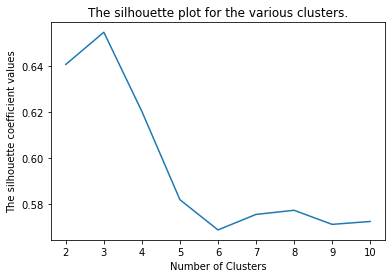

In [40]:
#finding ideal k val for number of clusters
sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(cluster_df)
  labels = kmeans.labels_
  sil.append(silhouette_score(cluster_df, labels, metric = 'euclidean'))
print(sil)

#Plot of cluster silhuette
plt.plot([2,3,4,5,6,7,8,9,10],sil)
plt.title("The silhouette plot for the various clusters.")
plt.xlabel("Number of Clusters")
plt.ylabel("The silhouette coefficient values")
#Ideal k is 3, good k is 4,7,8
#cluster_df

In [41]:
#Compute k means for decided number of clusters (k=3)
km = KMeans(n_clusters=3, random_state=1)
v = km.fit(cluster_df)
predict=km.predict(cluster_df)
cluster_df['Cluster'] = pd.Series(predict, index=cluster_df.index)

In [42]:
#tracts which we label as "gentrified"
cluster_df['Cluster'].where(cluster_df['Cluster']==1).dropna()

tract
612      1.0
7604     1.0
9000     1.0
11600    1.0
11700    1.0
12000    1.0
12102    1.0
Name: Cluster, dtype: float64

In [43]:
cluster_df

,total population,median housing value,median gross rent (dollars),estimate household income,percent college educated,percent non-white,percent multihousing unit,Cluster
tract,,,,,,,,
100,2298,259700,1071,1976,40.861619,27.806789,58.810409,2
200,1447,166700,919,1244,8.500346,89.357291,55.842185,0
300,1012,89000,817,841,6.225296,94.169960,49.613601,0
400,1945,119900,1104,1474,16.349614,84.164524,24.975892,0
601,532,104600,229,416,4.887218,100.000000,66.473988,0
...,...,...,...,...,...,...,...,...
14000,1805,75000,283,1323,2.326870,95.290859,91.570881,0
14100,1446,155600,915,1098,21.023513,69.156293,92.318436,0
14200,1503,174100,978,1379,27.079175,59.081836,59.761388,0


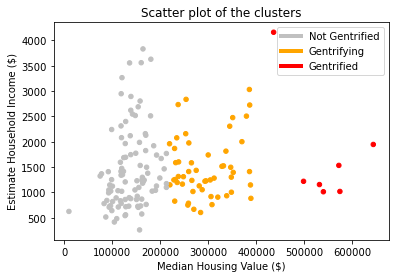

In [44]:
#Custom Colors
#cmap = colors.ListedColormap(['silver', 'powderblue', 'mediumslateblue'])
from matplotlib import colors
cmap = colors.ListedColormap(['silver', 'red', 'orange'])

#Custom Labels
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=cmap(0), lw=4),
                Line2D([0], [0], color=cmap(2), lw=4),
                Line2D([0], [0], color=cmap(1), lw=4)]

#Scatterplot of tracts
cluster_df.plot.scatter(x='median housing value',y='estimate household income', c='Cluster', cmap=cmap, colorbar = None, legend=None,sharex=False)
plt.title("Scatter plot of the clusters")
plt.xlabel("Median Housing Value ($)")
plt.ylabel("Estimate Household Income ($)")

#Legend
plt.legend(custom_lines, ['Not Gentrified', 'Gentrifying', 'Gentrified'])

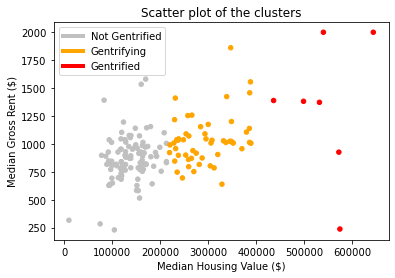

In [45]:
#Scatterplot of tracts
cluster_df.plot.scatter(x='median housing value',y='median gross rent (dollars)', c='Cluster', cmap=cmap, colorbar = None, legend=None,sharex=False)
plt.title("Scatter plot of the clusters")
plt.xlabel("Median Housing Value ($)")
plt.ylabel("Median Gross Rent ($)")

#Legend
plt.legend(custom_lines, ['Not Gentrified', 'Gentrifying', 'Gentrified'])

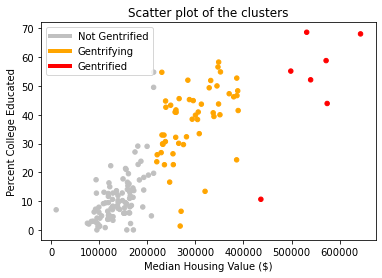

In [46]:
#Scatterplot of tracts
cluster_df.plot.scatter(x='median housing value',y='percent college educated', c='Cluster', cmap=cmap, colorbar = None, legend=None,sharex=False)
plt.title("Scatter plot of the clusters")
plt.xlabel("Median Housing Value ($)")
plt.ylabel("Percent College Educated")

#Legend
plt.legend(custom_lines, ['Not Gentrified', 'Gentrifying', 'Gentrified'])

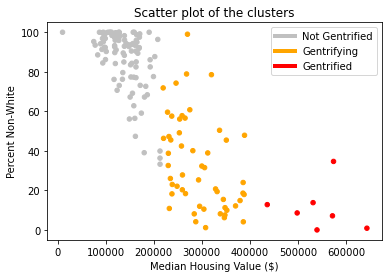

In [47]:
#Scatterplot of tracts
cluster_df.plot.scatter(x='median housing value',y='percent non-white', c='Cluster', cmap=cmap, colorbar = None, legend=None,sharex=False)
plt.title("Scatter plot of the clusters")
plt.xlabel("Median Housing Value ($)")
plt.ylabel("Percent Non-White")

#Legend
plt.legend(custom_lines, ['Not Gentrified', 'Gentrifying', 'Gentrified'])

In [49]:
#correlation table of variables
cluster_df.drop("Cluster",1).corr()

C:\Users\manue\AppData\Local\Temp\ipykernel_12508\291096424.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cluster_df.drop("Cluster",1).corr()


,total population,median housing value,median gross rent (dollars),estimate household income,percent college educated,percent non-white,percent multihousing unit
total population,1.000000,0.039086,0.192538,0.980965,-0.028881,-0.015413,-0.247903
median housing value,0.039086,1.000000,0.481625,0.121229,0.823560,-0.820684,-0.111679
median gross rent (dollars),0.192538,0.481625,1.000000,0.239700,0.473452,-0.486570,-0.288495
estimate household income,0.980965,0.121229,0.239700,1.000000,0.058488,-0.111470,-0.210982
percent college educated,-0.028881,0.823560,0.473452,0.058488,1.000000,-0.905269,-0.057332
percent non-white,-0.015413,-0.820684,-0.486570,-0.111470,-0.905269,1.000000,0.036797
percent multihousing unit,-0.247903,-0.111679,-0.288495,-0.210982,-0.057332,0.036797,1.000000


# Random Forest Data

**Random Forest Data Scraping**

In [50]:
acs5_2010_RandForest = json.dumps(c.acs5.state_county_tract(('B01003_001E',
                                                             'B25077_001E', 
                                                             'B25064_001E',
                                                             'B17026_001E','B17026_002E','B17026_003E','B17026_004E', 
                                                             'B09001_001E',
                                                             'B11007_001E','B11007_002E',
                                                             'B25005_001E',
                                                             'B25001_001E',
                                                             'B25024_006E','B25024_007E','B25024_009E','B25024_001E',
                                                             'B25008_001E','B25008_003E',
                                                             'B25070_007E','B25070_008E','B25070_009E','B25070_010E','B25070_001E',
                                                             'B24124_001E',
                                                             'B08301_001E','B08301_010E',
                                                             'B08201_001E','B08201_002E',
                                                             'B08201_005E','B08201_006E',
                                                             'B08534_001E','B08534_002E','B08534_003E','B08534_004E'), states.LA.fips, '071', Census.ALL, year=2010))
acs5_2010_RandForest_df = pd.read_json(acs5_2010_RandForest)

acs5_2010_RandForest_df.rename(columns={'B01003_001E': 'total population'}, inplace=True, errors='raise')
acs5_2010_RandForest_df.rename(columns={'B25001_001E': 'total housing units'}, inplace=True, errors='raise')
acs5_2010_RandForest_df.rename(columns={'B25077_001E': 'median housing value'}, inplace=True, errors='raise')
acs5_2010_RandForest_df.rename(columns={'B25064_001E': 'median gross rent (dollars)'}, inplace=True, errors='raise')

#for percent poverty
acs5_2010_RandForest_df['percent poverty'] = ((acs5_2010_RandForest_df['B17026_002E']+acs5_2010_RandForest_df['B17026_003E']+acs5_2010_RandForest_df['B17026_004E'])/acs5_2010_RandForest_df['B17026_001E'])*100
#for percent under 18
acs5_2010_RandForest_df['percent under 18'] = ((acs5_2010_RandForest_df['B09001_001E'])/acs5_2010_RandForest_df['total population']) * 100
#for percent household with resident over 65
acs5_2010_RandForest_df['percent household over 65'] = (acs5_2010_RandForest_df['B11007_002E']/acs5_2010_RandForest_df['B11007_001E']) *100
#for percent vacant land
acs5_2010_RandForest_df['percent vacant housing units'] = ((acs5_2010_RandForest_df['B25005_001E'])/acs5_2010_RandForest_df['total housing units'])*100
#for percent structures w/ 5+ units
acs5_2010_RandForest_df['percent 5 or more units'] = ((acs5_2010_RandForest_df['B25024_006E']+acs5_2010_RandForest_df['B25024_007E']+acs5_2010_RandForest_df['B25024_009E'])/acs5_2010_RandForest_df['B25024_001E'])*100
#for percent renter occupied
acs5_2010_RandForest_df['percent renter-occupied'] = (acs5_2010_RandForest_df['B25008_003E']/acs5_2010_RandForest_df['B25008_001E'])*100
#for percent rent burdened
acs5_2010_RandForest_df['percent rent burdened'] = ((acs5_2010_RandForest_df['B25070_007E']+acs5_2010_RandForest_df['B25070_008E']+acs5_2010_RandForest_df['B25070_009E']+acs5_2010_RandForest_df['B25070_010E'])/acs5_2010_RandForest_df['B25070_001E'])*100
#for percent employed
acs5_2010_RandForest_df['percent employed']= ((acs5_2010_RandForest_df['B24124_001E'])/acs5_2010_RandForest_df['total population'])*100
#for percent public transport
acs5_2010_RandForest_df['percent public transport'] = ((acs5_2010_RandForest_df['B08301_010E'])/acs5_2010_RandForest_df['B08301_001E'])*100
#for percent no car
acs5_2010_RandForest_df['percent no car'] = ((acs5_2010_RandForest_df['B08201_002E'])/acs5_2010_RandForest_df['B08201_001E'])*100
#for percent 3+car
acs5_2010_RandForest_df['percent 3 or more car'] = ((acs5_2010_RandForest_df['B08201_005E'] + acs5_2010_RandForest_df['B08201_006E'])/acs5_2010_RandForest_df['B08201_001E'])*100
#percent commute under 20 min
acs5_2010_RandForest_df['percent commute under 20min'] = ((acs5_2010_RandForest_df['B08534_002E']+acs5_2010_RandForest_df['B08534_003E']+acs5_2010_RandForest_df['B08534_004E'])/acs5_2010_RandForest_df['B08534_001E'])*100


#Set tract number as table label
acs5_2010_RandForest_df = acs5_2010_RandForest_df.set_index("tract")

#remove tracts for which most or some attributes are NaN
#1600 and 4402 have pop =0  and are thus problematic and may be needed to be ignored
#also have various missing 901 701 1730 1734 have one missing (rent burdened)
acs5_2010_RandForest_df.drop([14500,980000,980100,990000],inplace=True)
acs5_2010_RandForest_df.drop([1600,4402,901,701,1730,1734],inplace=True)


In [51]:
#these seems to not be available to Orleans Parish at tract level
#acs5_2010_RandForest_df[['B24124_001E','B08534_001E','B08534_002E','B08534_003E','B08534_004E']]

In [52]:
acs5_2010_RandForest_df.drop(['state','county',
                              #dropped bc only necessary for calculations
                              'total population','total housing units',
                              'B17026_001E','B17026_002E','B17026_003E','B17026_004E',
                              'B09001_001E',
                              'B11007_001E','B11007_002E',
                              'B25005_001E',
                              'B25024_006E','B25024_007E','B25024_009E','B25024_001E','B25008_001E','B25008_003E',
                              'B25070_007E','B25070_008E','B25070_009E','B25070_010E','B25070_001E',
                              'B24124_001E',
                              'B08301_001E','B08301_010E',
                              'B08201_001E','B08201_002E',
                              'B08201_005E','B08201_006E',
                              'B08534_001E','B08534_002E','B08534_003E','B08534_004E',
                              #dropped bc they seem to not be avalable for New Orleans tracts.
                              'percent employed','percent commute under 20min'
                              ], axis=1, inplace=True, errors='ignore')

#Num of cells where value is NAN
#print(acs5_2010_RandForest_df.isnull().sum().sum())
#Locate cells where value is NaN
for rowIndex, row in acs5_2010_RandForest_df.isnull().iterrows(): #iterate over rows
    for columnIndex, value in row.items():
        if value == True:
          x +=1
          print(x, rowIndex, columnIndex, end="\n")
#acs5_2010_RandForest_df.loc[[4402,1600,701,901,1730,1734]]
acs5_2010_RandForest_df.drop(acs5_2010_RandForest_df.loc[acs5_2010_RandForest_df['median housing value']< 0].index, inplace=True)
acs5_2010_RandForest_df.drop(acs5_2010_RandForest_df.loc[acs5_2010_RandForest_df['median gross rent (dollars)']< 0].index, inplace=True)
acs5_2010_RandForest_df

,median housing value,median gross rent (dollars),percent poverty,percent under 18,percent household over 65,percent vacant housing units,percent 5 or more units,percent renter-occupied,percent rent burdened,percent public transport,percent no car,percent 3 or more car
tract,,,,,,,,,,,,
100,259700,1071,3.488372,14.882507,12.881679,22.081784,0.669145,41.179039,34.916865,8.579272,5.152672,11.545802
200,166700,919,9.117647,19.903248,23.983740,25.341426,3.338392,57.912923,30.935252,24.000000,27.642276,4.065041
300,89000,817,14.349776,18.083004,27.725118,34.775889,0.000000,54.743083,59.898477,8.504399,40.758294,4.502370
400,119900,1104,12.400000,24.421594,21.910112,31.340405,1.832208,32.442159,55.905512,3.358613,9.691011,12.640449
601,104600,229,82.758621,31.203008,37.888199,6.936416,34.682081,83.270677,23.636364,0.000000,57.142857,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
14000,75000,283,43.317972,31.745152,30.423940,23.180077,63.314176,90.803324,26.657825,35.416667,64.339152,1.246883
14100,155600,915,31.785714,26.279391,9.363958,20.949721,22.067039,88.393489,54.780876,22.685789,24.558304,4.946996
14200,174100,978,3.254438,10.379242,11.796247,19.088937,0.867679,46.107784,43.626062,13.271605,26.809651,4.155496


In [53]:
acs5_2019_RandForest = json.dumps(c.acs5.state_county_tract(('B01003_001E',
                                                             'B25077_001E', 
                                                             'B25064_001E',
                                                             'B17026_001E','B17026_002E','B17026_003E','B17026_004E', 
                                                             'B09001_001E',
                                                             'B11007_001E','B11007_002E',
                                                             'B25005_001E',
                                                             'B25001_001E',
                                                             'B25024_006E','B25024_007E','B25024_009E','B25024_001E',
                                                             'B25008_001E','B25008_003E',
                                                             'B25070_007E','B25070_008E','B25070_009E','B25070_010E','B25070_001E',
                                                             'B24124_001E',
                                                             'B08301_001E','B08301_010E',
                                                             'B08201_001E','B08201_002E',
                                                             'B08201_005E','B08201_006E',
                                                             'B08534_001E','B08534_002E','B08534_003E','B08534_004E'), states.LA.fips, '071', Census.ALL, year=2019))
acs5_2019_RandForest_df = pd.read_json(acs5_2019_RandForest)

acs5_2019_RandForest_df.rename(columns={'B01003_001E': 'total population'}, inplace=True, errors='raise')
acs5_2019_RandForest_df.rename(columns={'B25001_001E': 'total housing units'}, inplace=True, errors='raise')
acs5_2019_RandForest_df.rename(columns={'B25077_001E': 'median housing value'}, inplace=True, errors='raise')
acs5_2019_RandForest_df.rename(columns={'B25064_001E': 'median gross rent (dollars)'}, inplace=True, errors='raise')

#for percent poverty
acs5_2019_RandForest_df['percent poverty'] = ((acs5_2019_RandForest_df['B17026_002E']+acs5_2019_RandForest_df['B17026_003E']+acs5_2019_RandForest_df['B17026_004E'])/acs5_2019_RandForest_df['B17026_001E'])*100
#for percent under 18
acs5_2019_RandForest_df['percent under 18'] = ((acs5_2019_RandForest_df['B09001_001E'])/acs5_2019_RandForest_df['total population']) * 100
#for percent household with resident over 65
acs5_2019_RandForest_df['percent household over 65'] = (acs5_2019_RandForest_df['B11007_002E']/acs5_2019_RandForest_df['B11007_001E']) *100
#for percent vacant land
acs5_2019_RandForest_df['percent vacant housing units'] = ((acs5_2019_RandForest_df['B25005_001E'])/acs5_2019_RandForest_df['total housing units'])*100
#for percent structures w/ 5+ units
acs5_2019_RandForest_df['percent 5 or more units'] = ((acs5_2019_RandForest_df['B25024_006E']+acs5_2019_RandForest_df['B25024_007E']+acs5_2019_RandForest_df['B25024_009E'])/acs5_2019_RandForest_df['B25024_001E'])*100
#for percent renter occupied
acs5_2019_RandForest_df['percent renter-occupied'] = (acs5_2019_RandForest_df['B25008_003E']/acs5_2019_RandForest_df['B25008_001E'])*100
#for percent rent burdened
acs5_2019_RandForest_df['percent rent burdened'] = ((acs5_2019_RandForest_df['B25070_007E']+acs5_2019_RandForest_df['B25070_008E']+acs5_2019_RandForest_df['B25070_009E']+acs5_2019_RandForest_df['B25070_010E'])/acs5_2019_RandForest_df['B25070_001E'])*100
#for percent employed
acs5_2019_RandForest_df['percent employed']= ((acs5_2019_RandForest_df['B24124_001E'])/acs5_2019_RandForest_df['total population'])*100
#for percent public transport
acs5_2019_RandForest_df['percent public transport'] = ((acs5_2019_RandForest_df['B08301_010E'])/acs5_2019_RandForest_df['B08301_001E'])*100
#for percent no car
acs5_2019_RandForest_df['percent no car'] = ((acs5_2019_RandForest_df['B08201_002E'])/acs5_2019_RandForest_df['B08201_001E'])*100
#for percent 3+car
acs5_2019_RandForest_df['percent 3 or more car'] = ((acs5_2019_RandForest_df['B08201_005E'] + acs5_2019_RandForest_df['B08201_006E'])/acs5_2019_RandForest_df['B08201_001E'])*100
#percent commute under 20 min
acs5_2019_RandForest_df['percent commute under 20min'] = ((acs5_2019_RandForest_df['B08534_002E']+acs5_2019_RandForest_df['B08534_003E']+acs5_2019_RandForest_df['B08534_004E'])/acs5_2019_RandForest_df['B08534_001E'])*100

#Set tract number as table label
acs5_2019_RandForest_df = acs5_2019_RandForest_df.set_index("tract")

#remove tracts for which most or some attributes are NaN
#1600 and 4402 have pop =0  and are thus problematic and may be needed to be ignored
#also have various missing 901 701 1730 1734 have one missing (rent burdened)
acs5_2019_RandForest_df.drop([14500,980000,980100,990000],inplace=True)
#in 2019 only 1600 remains probelmatic with pop=0, but for simplicity and consitency we will drop the same as before
acs5_2019_RandForest_df.drop([1600,4402,901,701,1730,1734],inplace=True)


acs5_2019_RandForest_df.drop(['state','county',
                              #dropped bc only necessary for calculations
                              'total population','total housing units',
                              'B17026_001E','B17026_002E','B17026_003E','B17026_004E',
                              'B09001_001E',
                              'B11007_001E','B11007_002E',
                              'B25005_001E',
                              'B25024_006E','B25024_007E','B25024_009E','B25024_001E','B25008_001E','B25008_003E',
                              'B25070_007E','B25070_008E','B25070_009E','B25070_010E','B25070_001E',
                              'B24124_001E',
                              'B08301_001E','B08301_010E',
                              'B08201_001E','B08201_002E',
                              'B08201_005E','B08201_006E',
                              'B08534_001E','B08534_002E','B08534_003E','B08534_004E',
                              #dropped bc they seem to not be avalable for New Orleans tracts.
                              'percent employed','percent commute under 20min'
                              ], axis=1, inplace=True, errors='ignore')

#Num of cells where value is NAN
print(acs5_2019_RandForest_df.isnull().sum().sum())
#Locate cells where value is NaN
for rowIndex, row in acs5_2019_RandForest_df.isnull().iterrows(): #iterate over rows
    for columnIndex, value in row.items():
        if value == True:
          x +=1
          print(x, rowIndex, columnIndex, end="\n")
#acs5_2019_RandForest_df.loc[[4402,1600,701,901,1730,1734]]
#I guess 2019 does not have problems wiht nan values in housing value or gross rent...
#acs5_2019_RandForest_df[acs5_2019_RandForest_df['median housing value'] <= 0].drop
#acs5_2019_RandForest_df[acs5_2019_RandForest_df['median gross rent (dollars)'] <= 0].drop
acs5_2019_RandForest_df.drop(acs5_2019_RandForest_df.loc[acs5_2019_RandForest_df['median housing value']< 0].index, inplace=True)
acs5_2019_RandForest_df.drop(acs5_2019_RandForest_df.loc[acs5_2019_RandForest_df['median gross rent (dollars)']< 0].index, inplace=True)
acs5_2019_RandForest_df


0


,median housing value,median gross rent (dollars),percent poverty,percent under 18,percent household over 65,percent vacant housing units,percent 5 or more units,percent renter-occupied,percent rent burdened,percent public transport,percent no car,percent 3 or more car
tract,,,,,,,,,,,,
1744,187500,931,39.134809,34.865602,13.028953,10.110110,41.641642,74.039399,63.518385,5.027322,14.420935,8.296214
1746,123200,1094,20.743920,24.413646,24.773609,16.522678,0.000000,49.270270,67.088608,13.427800,19.663648,12.613195
1745,161500,1013,26.395939,27.396920,31.640058,13.713212,4.508453,38.839063,60.884956,2.610966,19.448476,15.094340
1747,277700,861,3.553299,17.870370,32.046864,2.420982,0.000000,3.796296,63.013699,2.261790,0.000000,33.907650
1748,156700,1058,13.689840,22.807018,21.815889,9.681093,0.911162,22.781336,27.520436,4.480874,8.575032,16.015132
...,...,...,...,...,...,...,...,...,...,...,...,...
618,257600,1061,7.658059,26.215774,34.942216,5.096774,2.451613,26.665304,64.308682,2.732240,7.138001,23.861319
1743,254600,875,34.257426,33.079696,14.170040,24.695122,40.853659,53.103724,60.925040,16.533333,16.700405,6.983806
14300,124000,768,48.709677,20.619127,28.161669,21.814475,24.057085,60.720222,63.651591,18.197574,54.498044,1.173403


# Principal Component Analysis


In [54]:
#Need to add label from k means on wether getrified or not

#acs5_2010_RandForest_df.head
#standarizing data since PCA output is influences based on the scale of the features of the data.
features = acs5_2010_RandForest_df.columns.values.tolist()
features
a = acs5_2010_RandForest_df.loc[:,features].values
a = StandardScaler().fit_transform(a)
#Check values are normalized
#np.mean(a),np.std(a)
#conver array to df set index to be tracts.
normalised= pd.DataFrame(a,columns=features, index = acs5_2010_RandForest_df.index)
#select number of components for PCA
pca = PCA(n_components = 5)
#array of 167 entries with 2 components
PCAacs5 = pca.fit_transform(a)
#PCAacs5
PCAacs5_df= pd.DataFrame(PCAacs5,columns=['component 1','component 2','component 3','component 4','component 5'], index = acs5_2010_RandForest_df.index)
PCAacs5_df
#print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
#gain a little more data the more dimension we have in PCA, eventually it is not worth it.
#for 2 Explained variation per principal component: [0.29533698 0.16360189]
#for 3 Explained variation per principal component: [0.29533698 0.16360189 0.12057578]
#for 4 Explained variation per principal component: [0.29533698 0.16360189 0.12057578 0.09201559]

cluster_df["Cluster"]
PCAacs5_df["Cluster"] = cluster_df["Cluster"]
print(PCAacs5_df["Cluster"].where(PCAacs5_df["Cluster"] == 1).dropna())
#Tracts which would seem to be gentrified- 612 7604 9000 11600 11700 12000 12102
#PCAacs5_df.loc['1']
PCAacs5_df

tract
612      1.0
7604     1.0
9000     1.0
11600    1.0
11700    1.0
12000    1.0
12102    1.0
Name: Cluster, dtype: float64


,component 1,component 2,component 3,component 4,component 5,Cluster
tract,,,,,,
100,-2.069448,0.352961,-0.124538,-0.508485,-0.748668,2
200,0.550612,0.506445,1.332698,-0.409472,-1.164376,0
300,1.274386,-0.353050,0.554035,1.199439,-0.670465,0
400,-1.109342,-1.472835,-0.323498,0.559905,0.017766,0
601,4.074779,0.556351,3.126945,-2.058279,2.518933,0
...,...,...,...,...,...,...
14000,5.240450,1.829129,2.177833,-1.875262,2.092509,0
14100,1.840971,0.680967,-0.991951,-1.864931,-0.478292,0
14200,-0.533189,1.009983,-0.059529,-0.392652,-1.520942,0


# Random Forest

In [55]:
#PCAacs5_df
dependent = PCAacs5_df[['component 1','component 2','component 3','component 4','component 5']]
independent = PCAacs5_df[['Cluster']]
dependent_train, dependent_test, independent_train, independent_test = train_test_split(dependent, independent, test_size=0.3)
clf=RandomForestClassifier(n_estimators=100) 
clf.fit(dependent_train,independent_train)
independent_pred=clf.predict(dependent_test)
#We dont have too many variables for random forest, and thus PCA actually diminishes accuracy, we decided to not use it. 
print("Accuracy:",metrics.accuracy_score(independent_test, independent_pred))


C:\Users\manue\AppData\Local\Temp\ipykernel_12508\864823098.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(dependent_train,independent_train)


Accuracy: 0.75


In [56]:
#accuracy says to be better without PCA...
#acs5_2010_RandForest_df
copy2010_df = acs5_2010_RandForest_df.copy()
copy2010_df["Cluster"] = cluster_df["Cluster"]
dependent = copy2010_df[copy2010_df.keys()]
dependent.pop('Cluster')
independent = copy2010_df[['Cluster']]
dependent_train, dependent_test, independent_train, independent_test = train_test_split(dependent, independent, test_size=0.3)
clf=RandomForestClassifier(n_estimators=50) 
clf.fit(dependent_train,independent_train)
independent_pred=clf.predict(dependent_test)
print("Accuracy:",metrics.accuracy_score(independent_test, independent_pred))

#Get 2019 data for predicting
copy2019_df = acs5_2019_RandForest_df.copy()
dependent_predict = copy2019_df


dependent_predict
#dependent_train
prediction = clf.predict(dependent_predict)
prediction_df = pd.DataFrame(prediction, columns = ['Cluster']).set_index(copy2019_df.index)
prediction_df.where(prediction_df["Cluster"]==1).dropna()
copy2010_df["Predicted_Cluster"] = prediction_df
prediction_df.where(prediction_df["Cluster"]==1).dropna()
#Cluster values labeled "gentrified"612 7604 9000 11600 11700 12000 12102 
#some variance in the model, I have seen it do prev values and add 

Accuracy: 0.9791666666666666


C:\Users\manue\AppData\Local\Temp\ipykernel_12508\535138945.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(dependent_train,independent_train)


,Cluster
tract,
11600,1.0
612,1.0
4100,1.0
5602,1.0
11400,1.0
12101,1.0
7604,1.0
11900,1.0
9000,1.0


In [57]:
copy2019_df['PREDICTED_CLUSTER'] = clf.predict(copy2019_df)

In [58]:
acs5_2019_Cluster_df

,median housing value,median gross rent (dollars),estimate household income,percent college educated,percent non-white,percent multihousing unit
tract,,,,,,
1744,187500,931,3619,10.342813,99.396182,76.226226
1746,123200,1094,2949,10.314499,95.549041,19.546436
1745,161500,1013,3270,21.684054,95.901639,36.819036
1747,277700,861,3754,34.953704,100.000000,4.505716
1748,156700,1058,3563,13.761677,94.121668,5.296128
...,...,...,...,...,...,...
618,257600,1061,3773,34.797711,75.643645,25.096774
1743,254600,875,1780,16.980376,95.915098,69.359756
14300,124000,768,1474,7.739082,97.014925,85.728848


In [59]:
Ellen_Ding_df = (acs5_2019_Cluster_df - acs5_2010_Cluster_df)
Ellen_Ding_df[Ellen_Ding_df['percent college educated']>=50]

,estimate household income,median gross rent (dollars),median housing value,percent college educated,percent multihousing unit,percent non-white,total population
tract,,,,,,,


In [60]:
#To create predictions, we use 2010 data as the dependent data
#                              2010 labels and 2019 labels as independent data
#                              then plug 2019 data (sample), should predict 2019 and 2028 labels
#                              .fit(dependent_train,independent_train)
#                              .predict(depentent_test)>independent_test
#                              .predict(depentent_sample)>independent_sample

In [61]:
prediction_df

,Cluster
tract,
1744,0
1746,0
1745,0
1747,2
1748,0
...,...
618,2
1743,2
14300,0


<AxesSubplot:>

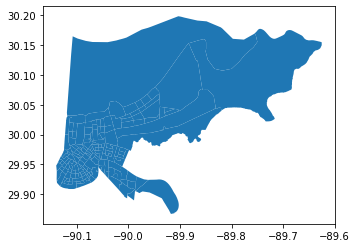

In [4]:
import geopandas as gpd
nola_map = gpd.read_file('./2019_shapefiles/tl_2019_22_tract.shp')
nola_map = nola_map[nola_map['COUNTYFP'] == '071']

#Map of all Orleans Parish Tracts
nola_map['TRACTCE'] = nola_map['TRACTCE'].astype('int64')
nola_map.plot()


<AxesSubplot:>

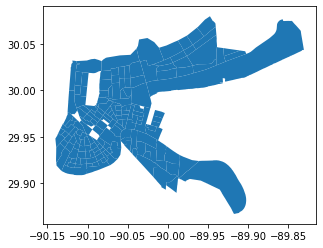

In [63]:
#Map of Applicable Orleans Parish tracts
map_test_df = nola_map.merge(prediction_df, how="inner", left_on="TRACTCE", right_on="tract")
map_test_df.plot()

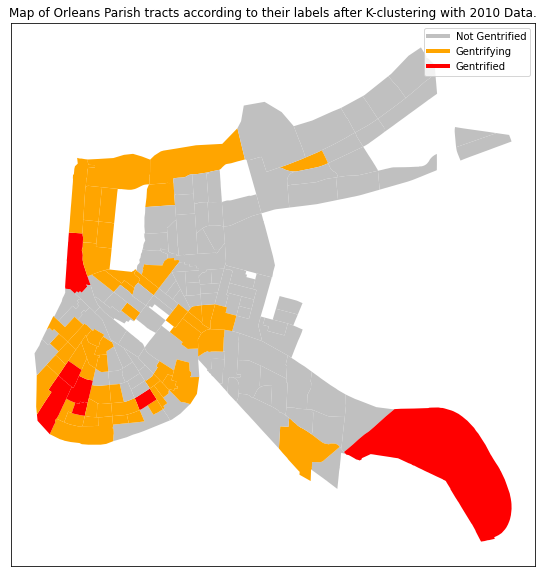

In [79]:
cluster_df['Cluster'] = pd.Series(predict, index=cluster_df.index)
cluster_df['Cluster']


map_cluster_df = nola_map.merge(cluster_df['Cluster'], how="inner", left_on="TRACTCE", right_on="tract")
map_cluster_df




map_cluster_df.plot(map_cluster_df['Cluster'], figsize=(100,10), cmap=cmap, label=map_test_df['Cluster'], legend=None)

plt.title('Map of Orleans Parish tracts according to their labels after K-clustering with 2010 Data.')
plt.rcParams['axes.facecolor'] = 'white'

#Legend
plt.legend(custom_lines, ['Not Gentrified', 'Gentrifying', 'Gentrified'])
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)

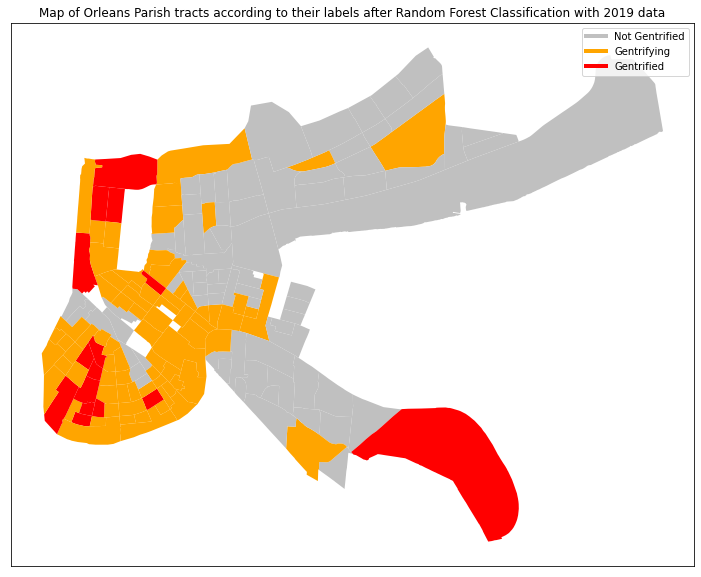

In [83]:

map_test_df.plot(map_test_df['Cluster'], figsize=(100,10), cmap=cmap, label=map_test_df['Cluster'], legend=None)

plt.title('Map of Orleans Parish tracts according to their labels after Random Forest Classification with 2019 data')
plt.rcParams['axes.facecolor'] = 'white'

#Legend
plt.legend(custom_lines, ['Not Gentrified', 'Gentrifying', 'Gentrified'])
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)

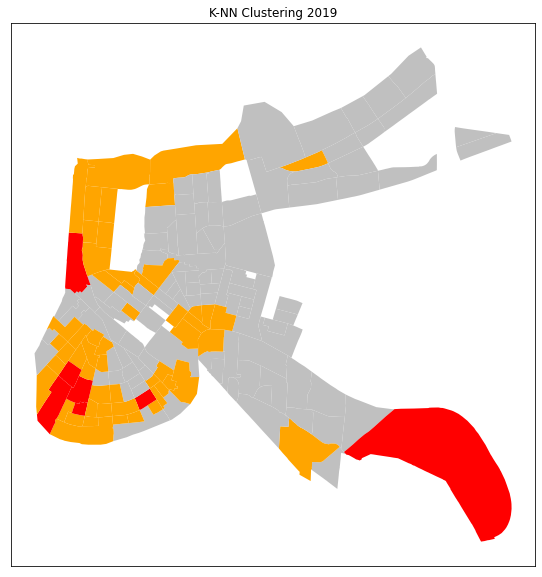

In [78]:
pca_map_test = nola_map.merge(PCAacs5_df, how="inner", left_on="TRACTCE", right_on="tract")
pca_map_test

pca_map_test.plot(pca_map_test['Cluster'], figsize=(100,10), cmap=cmap, label=pca_map_test['Cluster'], legend=None)

plt.title('K-NN Clustering 2019')
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)